#### Import required layers and utils from the framework

In [1]:
import keras

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from keras import callbacks
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, merge, Input, Lambda, BatchNormalization
from keras.layers import Convolution2D, Convolution3D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as K


# from theano.sandbox.cuda.dnn import *

Using TensorFlow backend.


#### Import other required utils

In [2]:
from copy import deepcopy
import datetime
import dicom
from fnmatch import fnmatch
import h5py
import numpy as np
import os
from os import path, walk
import pandas as pd
import pickle
from PIL import Image, ImageDraw
import re
import time
from matplotlib import pyplot as plt
from scipy.misc.pilutil import imresize

%matplotlib inline
plt.set_cmap('gray')

#### sci-kit learn stuff

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
DICOM_PREFIX = "/home/a.kondyukov/data/Indianapolis_dicom/"
MASK_PREFIX  = "/home/a.kondyukov/data/Indianapolis_masks_new/"

BATCH_SIZE = 5
EPOCH_NUM = 300

X_IMAGE_SIZE = 512
IMAGE_SIZE = 512

STRUCTURE = "lung"
EXPERIMENT_NAME = "%s_segmentation_indiana" % STRUCTURE
OUT_DIR = "/home/a.kondyukov/data/out/%s/" % EXPERIMENT_NAME
DO_LRN = True # LRN is Local Response Normalization (lateral inhibition)

MODEL_FILENAME = "%s_u-net_%s" % (EXPERIMENT_NAME, datetime.date.today().strftime("%d%b%Y"))

In [ ]:
images = []
masks = []
cases = []

for case in ["atherosclerosis", "calcinosis", "cardiomegaly_mild", "cardiomegaly_modsev", "normal", "tortuous_aorta"]:

    filenames = !ls /home/a.kondyukov/data/Indianapolis_masks_new/"$case"_masks/ | grep ".png$"
    
    max_iter = len(filenames)
    print("case: " + case)
    for counter, mask_filename in enumerate(filenames):
        print("\r", "%.2f" % (counter / max_iter * 100) + "%", end="")
        
        image_filename = re.sub(r"([0-9]+)(.*).png", DICOM_PREFIX + r"\1/\1\2", mask_filename)
        image = imresize(dicom.read_file(image_filename).pixel_array, [IMAGE_SIZE, IMAGE_SIZE])
        mask_filename = os.path.join(MASK_PREFIX, case+"_masks", mask_filename)
        mask = (imresize(plt.imread(mask_filename).mean(axis=2), [IMAGE_SIZE, IMAGE_SIZE]) > 0.5).astype(int)
        
        images.append(image)
        masks.append(mask)
        cases.append(case)

In [ ]:
images = np.array(images)
masks = np.array(masks)
cases = np.array(cases)

#### This version of U-net uses zero-padding so as to leave image size unchanged

In [29]:
smooth = 1.

In [30]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [36]:
def get_unet():
    inputs = Input((1, IMAGE_SIZE, IMAGE_SIZE))
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer="adam", loss="binary_crossentropy")

    return model

In [19]:
def get_unet():
    inputs = Input((1, IMAGE_SIZE, IMAGE_SIZE))
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)

    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(4, 4))(conv3)

    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(4, 4))(conv4)

    conv5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool5)
    conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    flatten = Flatten()(pool6)

#     dense_1 = Dense(1024, activation="relu")(flatten)
#     dropout_1 = Dropout(0.3)(dense_1)
    
#     dense_2 = Dense(1024, activation="relu")(dropout_1)
#     dropout_2 = Dropout(0.3)(dense_2)
    
    dense_3 = Dense(1024, activation="relu")(flatten)
    dropout_3 = Dropout(0.3)(dense_3)
    
    dense_4 = Dense(6, activation="sigmoid")(dropout_3)

    model = Model(input=inputs, output=dense_4)

    return model

In [77]:
def get_vgg():
    img_input = Input(shape=(1, 512, 512))
    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(6, activation='softmax', name='predictions')(x)
    
    model = Model(img_input, x, name='vgg19')
    
    return model

In [81]:
from keras.utils.data_utils import get_file

model = get_vgg()

weights_url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'

weights_path = get_file('vgg19_weights_th_dim_ordering_tf_kernels.h5', weights_url, cache_subdir='models')
model.load_weights(weights_path)

KeyboardInterrupt: 

In [37]:
model = get_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [43]:
new_model = Sequential()
for l in model.layers[:13]:
    new_model.add(l)
    
new_model.add(Flatten())
new_model.add(Dense(1024, activation="relu"))
new_model.add(Dropout(0.5))
new_model.add(Dense(1024, activation="relu"))
new_model.add(Dropout(0.5))
new_model.add(Dense(6, activation="softmax"))

In [61]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [38]:
model.load_weights("../models/lung_segmentation_indiana_u-net_05Apr2017_299.h5")

In [ ]:
train_indices, validate_indices = train_test_split(range(len(images)))

In [ ]:
X = images
# Y = masks
Y = pd.get_dummies(cases).values

In [ ]:
print(X.shape, Y.shape)
print(X.max(), Y.max())

In [ ]:
train_test_file = np.load("train_test_sep.npz")
train_indices = train_test_file["train_indices"]
validate_indices = train_test_file["validate_indices"]

In [ ]:
X_train, X_validate = images[train_indices, None, :, :], images[validate_indices, None, :, :]
# Y_train, Y_validate = masks[train_indices, None, :, :], masks[validate_indices, None, :, :]
Y_train, Y_validate = Y[train_indices], Y[validate_indices]

In [ ]:
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
# with open(OUT_DIR + "train_test_sep11", "w+") as f:
np.savez_compressed(OUT_DIR + "train_test_sep11", train_indices=train_indices, validate_indices=validate_indices)

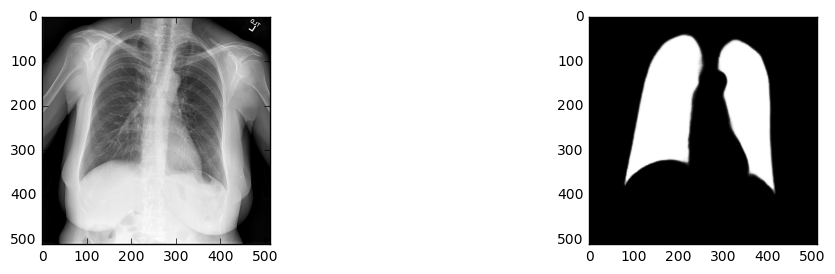

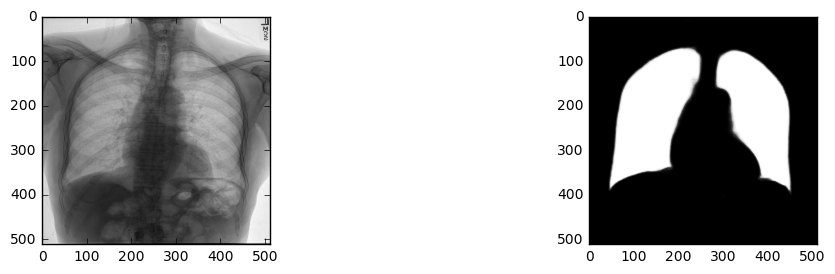

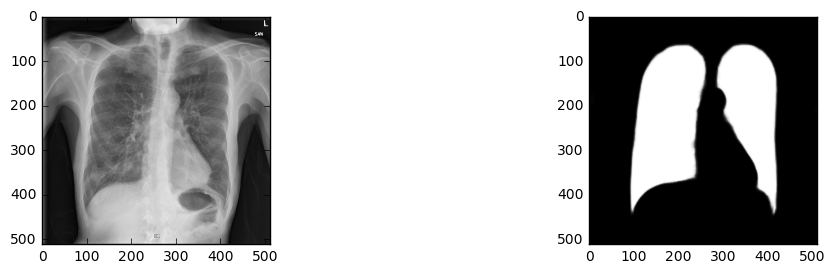

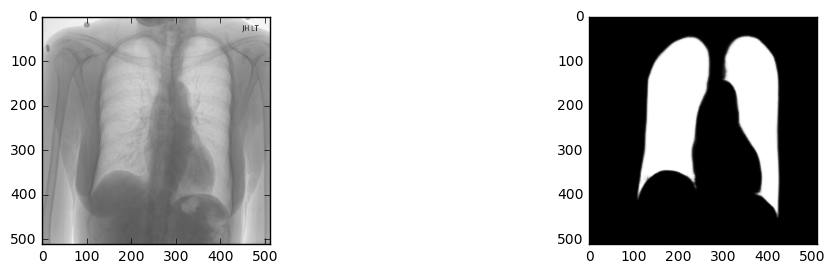

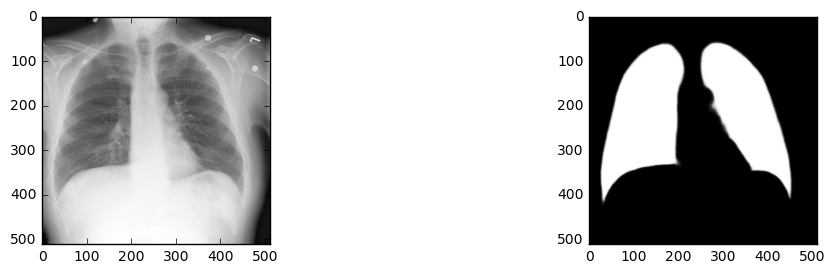

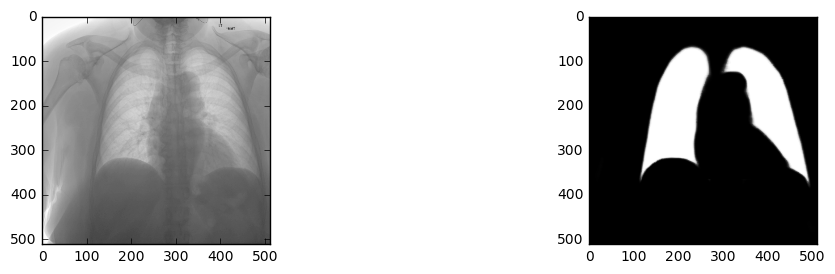

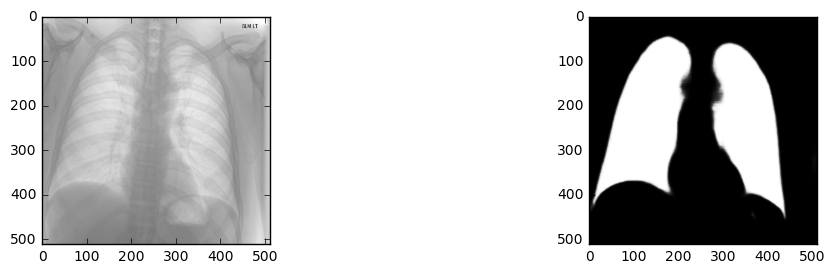

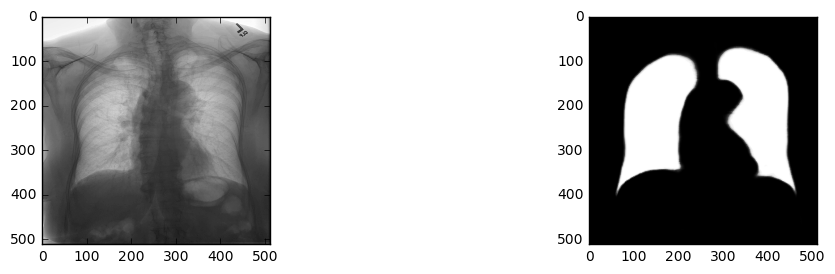

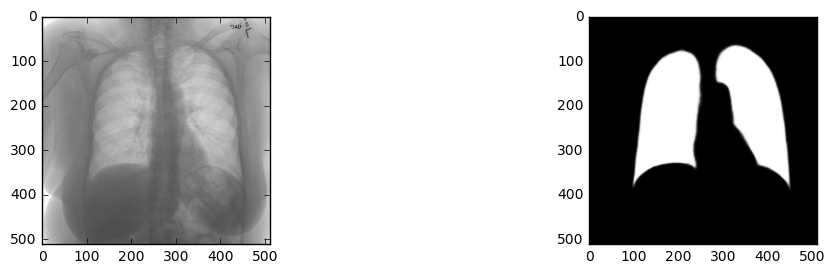

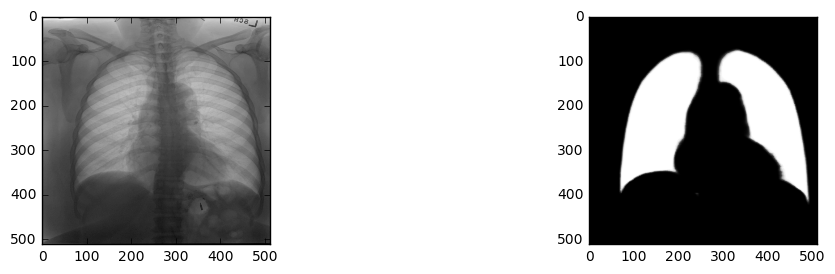

In [39]:
for i in range(10):
    plt.figure(i, figsize=(10, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(X_train[i][0])
#     plt.subplot(1, 3, 2)
#     plt.imshow(Y_train[i][0])
    plt.subplot(1, 3, 3)
    plt.imshow(model.predict(np.array([X_train[i]]))[0][0])

In [ ]:
datagen = ImageDataGenerator(
                    featurewise_center=False,
                    featurewise_std_normalization=False,
                    rotation_range=10.,
                    zoom_range=0.1,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    fill_mode='constant',
                    cval=0.,
                    horizontal_flip=True)

for ep in range(300):
    e = ep + 0
    print('Epoch', e)
    batches = 0
    
#     X_batch = np.zeros((BATCH_SIZE, 1, X_IMAGE_SIZE, X_IMAGE_SIZE))
#     Y_batch = np.zeros((BATCH_SIZE, 1, X_IMAGE_SIZE, X_IMAGE_SIZE))

    train_losses = []
    epoch_finished = False
    start = time.time()

    print("\r", "0%", end="")
    max_iter = X_train.shape[0] // BATCH_SIZE + (X_train.shape[0] % BATCH_SIZE != 0)
    
#     for i, X_batch in enumerate(datagen.flow(np.concatenate([X_train, Y_train, np.zeros_like(X_train)], axis=1), 
#                                 batch_size=BATCH_SIZE)):

    for i, (X_batch, Y_batch) in enumerate(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)):

        print("\r", "%.2f" % (i / max_iter * 100) + "%", end="")
#         Y_batch = np.expand_dims(X_batch[:, 1, :, :], 1)
#         X_batch = np.expand_dims(X_batch[:, 0, :, :], 1)

        loss = model.train_on_batch(X_batch, Y_batch)
        train_losses.append(loss)
        batches += 1
        if batches >= len(X_train) / 5:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            validation_loss = model.evaluate(X_validate, Y_validate, verbose=0)
            print('train loss: ', np.mean(train_losses), 
                  'validation loss: ', validation_loss)
            break
                
#     if e % 50 == 0:
    model.save_weights("../models1/" + MODEL_FILENAME + '_' + str(e) + '.h5', overwrite=True)
    print('Time per epoch: ', time.time() - start)
        

# model.save_weights("./models/" + MODEL_FILENAME + '.h5', overwrite=True)

In [ ]:
np.savez_compressed("xy.npz", X_train=X_train, X_validate=X_validate, Y_train=Y_train, Y_validate=Y_validate)

In [10]:
xyfile = np.load("xy.npz")
X_train, X_validate = xyfile["X_train"], xyfile["X_validate"]
Y_train, Y_validate = xyfile["Y_train"], xyfile["Y_validate"]

In [12]:
X_train.shape

(246, 1, 512, 512)

In [15]:
X_train[:5].shape

(5, 1, 512, 512)

In [63]:
datagen = ImageDataGenerator(
                    featurewise_center=False,
                    featurewise_std_normalization=False,
                    rotation_range=10.,
                    zoom_range=0.1,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    fill_mode='constant',
                    cval=0.,
                    horizontal_flip=True)

callback = callbacks.ModelCheckpoint("../models2/" + "weights.{epoch:02d}-{val_acc:.2f}.hdf5", 
                                           monitor='val_loss', 
                                           verbose=1, 
                                           save_best_only=False, 
                                           save_weights_only=False, 
                                           mode='auto', period=5)

new_model.fit_generator(datagen.flow(X_train, Y_train, 
                    batch_size=8),
                    samples_per_epoch=len(X_train) * 10, 
                    nb_epoch=300, 
                    callbacks=[callback],
                    validation_data=(X_validate, Y_validate))

Epoch 1/300
2460/2460 [==============================] - 556s - loss: 12.7962 - acc: 0.2061 - val_loss: 12.7765 - val_acc: 0.2073
Epoch 2/300
2460/2460 [==============================] - 558s - loss: 12.3179 - acc: 0.2358 - val_loss: 12.7765 - val_acc: 0.2073
Epoch 3/300
2460/2460 [==============================] - 554s - loss: 12.3179 - acc: 0.2358 - val_loss: 12.7765 - val_acc: 0.2073
Epoch 4/300
2460/2460 [==============================] - 552s - loss: 12.3179 - acc: 0.2358 - val_loss: 12.7765 - val_acc: 0.2073
Epoch 5/300
2460/2460 [==============================] - 563s - loss: 12.3179 - acc: 0.2358 - val_loss: 12.7765 - val_acc: 0.2073
Epoch 6/300
2460/2460 [==============================] - 554s - loss: 12.3179 - acc: 0.2358 - val_loss: 12.7765 - val_acc: 0.2073
Epoch 7/300
  40/2460 [..............................] - ETA: 534s - loss: 13.2974 - acc: 0.1750

KeyboardInterrupt: 

In [ ]:
for i in range(10):
    plt.figure(i, figsize=(12, 12))
    plt.imshow((model.predict(np.array([X_validate[i]]))[0][0] + 0.9) * X_validate[i][0])

In [ ]:
Y_pred = model.predict(X_validate)

In [ ]:
jaccard = \
    ((Y_pred > 0.5) & Y_validate.astype(np.bool)).mean() / ((Y_pred > 0.5) | Y_validate.astype(np.bool)).mean()

In [ ]:
jaccard